In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

In [2]:
import geopandas as gpd
import pandas as pd
from siuba import *
import numpy as np

from segment_speed_utils import helpers, gtfs_schedule_wrangling
from shared_utils import rt_dates, gtfs_utils_v2
import folium
import itertools

In [3]:
from update_vars import (analysis_date, AM_PEAK, PM_PEAK, EXPORT_PATH, GCS_FILE_PATH, PROJECT_CRS,
SEGMENT_BUFFER_METERS, AM_PEAK, PM_PEAK, HQ_TRANSIT_THRESHOLD, MS_TRANSIT_THRESHOLD)

In [4]:
import sjoin_stops_to_segments

In [5]:
import create_aggregate_stop_frequencies

In [12]:
import importlib
importlib.reload(create_aggregate_stop_frequencies)

<module 'create_aggregate_stop_frequencies' from '/home/jovyan/data-analyses/high_quality_transit_areas/create_aggregate_stop_frequencies.py'>

In [7]:
am_peak_hrs = list(range(AM_PEAK[0].hour, AM_PEAK[1].hour))
pm_peak_hrs = list(range(PM_PEAK[0].hour, PM_PEAK[1].hour))
both_peaks_hrs = am_peak_hrs + pm_peak_hrs

In [8]:
analysis_date

'2024-10-21'

In [9]:
stop_times = helpers.import_scheduled_stop_times(
    analysis_date,
    get_pandas = True,
)

In [13]:
stop_times = create_aggregate_stop_frequencies.add_route_dir(stop_times, analysis_date)

In [14]:
st_prepped = stop_times.pipe(create_aggregate_stop_frequencies.prep_stop_times)

## multi logic

In [15]:
multi_test2 = create_aggregate_stop_frequencies.stop_times_aggregation_max_by_stop(st_prepped, analysis_date, single_route_dir=False)

## single logic

In [16]:
single_test2 = create_aggregate_stop_frequencies.stop_times_aggregation_max_by_stop(st_prepped, analysis_date, single_route_dir=True)

## create count of shared stops between each route_dir

In [17]:
def get_explode_multiroute_only(
    single_route_aggregation: pd.DataFrame,
    multi_route_aggregation: pd.DataFrame,
    frequency_thresholds: tuple,
) -> pd.DataFrame:
    '''
    Shrink the problem space for the compute-intensive collinearity screen.
    First, get stops with any chance of qualifying as a major stop/hq corr for
    both single and multi-route aggregations.
    Then get stops that appear in multi-route qualifiers only, these will go to
    further processing.
    '''
    #  note this is max -- still evaluate stops meeting the lower threshold as single-route in case they meet the higher threshold as multi
    single_qual = single_route_aggregation >> filter(_.am_max_trips_hr >= max(frequency_thresholds), _.pm_max_trips_hr >= max(frequency_thresholds))
    multi_qual = multi_route_aggregation >> filter(_.am_max_trips_hr >= min(frequency_thresholds), _.pm_max_trips_hr >= min(frequency_thresholds))
    multi_only = multi_qual >> anti_join(_, single_qual, on=['schedule_gtfs_dataset_key', 'stop_id'])
    print(f'{multi_only.shape[0]} stops may qualify with multi-route aggregation')
    multi_only_explode = (multi_only[['schedule_gtfs_dataset_key', 'stop_id', 'route_dir']]
    .explode('route_dir')
    .sort_values(['schedule_gtfs_dataset_key','stop_id', 'route_dir'])) #  sorting crucial for next step
    return multi_only_explode

In [18]:
multi_only_explode = get_explode_multiroute_only(single_test2, multi_test2, (HQ_TRANSIT_THRESHOLD, MS_TRANSIT_THRESHOLD))

13593 stops may qualify with multi-route aggregation


In [19]:
multi_only_explode >> head(3)

,schedule_gtfs_dataset_key,stop_id,route_dir
10,0139b1253130b33adcd4b3a4490530d2,0a2a817a-d35d-434d-b039-6a78d79d7602,3ff1b747-a791-4eb3-90b2-25cb355b6c67_0
10,0139b1253130b33adcd4b3a4490530d2,0a2a817a-d35d-434d-b039-6a78d79d7602,91673676-969b-4c0a-a233-158c98c522dc_0
10,0139b1253130b33adcd4b3a4490530d2,0a2a817a-d35d-434d-b039-6a78d79d7602,T6_0


In [20]:
def accumulate_share_count(route_dir_exploded: pd.DataFrame):
    '''
    For use via pd.DataFrame.groupby.apply
    Accumulate the number of times each route_dir shares stops with
    each other in a dictionary (share_counts)
    '''
    global share_counts
    rt_dir = route_dir_exploded.route_dir.to_numpy()
    schedule_gtfs_dataset_key = route_dir_exploded.schedule_gtfs_dataset_key.iloc[0]
    for route_dir in rt_dir:
        route = route_dir.split('_')[0] #  don't compare opposite dirs of same route, leads to edge cases like AC Transit 45
        other_dirs = [x for x in rt_dir if x != route_dir and x.split('_')[0] != route]
        for other_dir in other_dirs:
            key = schedule_gtfs_dataset_key+'__'+route_dir+'__'+other_dir
            if key in share_counts.keys():
                share_counts[key] += 1
            else:
                share_counts[key] = 1

In [21]:
share_counts = {}
multi_only_explode.groupby(['schedule_gtfs_dataset_key', 'stop_id']).apply(accumulate_share_count)

""


In [22]:
# share_counts

In [23]:
s = pd.Series(share_counts.values())

<AxesSubplot:>

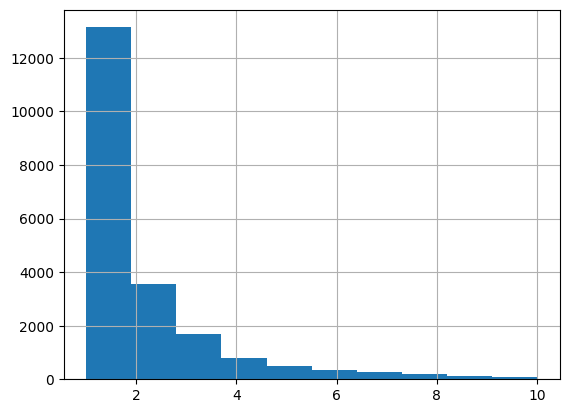

In [24]:
(s[s<11]).hist()

### Which threshold?

* 8 catches Muni 48 and 66, which are somewhat marginal but not an edge case per se

In [25]:
# qualify

## lookup function/filtering steps

1. If a feed has no route_direction pairs qualifying, by definition no stops will qualify. Can exclude feed from next steps.
1. Get a list of unique feeds where at least one route_directions pair qualifies to evaluate.
1. Get stop_times filtered to that feed, and filter that to stops that only qualify with multiple routes, and route directions that pair with at least one other route_direction. Do not consider pairs between the same route in one direction and the same route in the opposite direction.
1. After that filtering, check again if stop_times includes the minimum frequency to qualify at each stop. Exclude stops where it doesn't.
1. Then... evaluate which route_directions can be aggregated at each remaining stop. From the full list of route_directions (sorted by frequency) serving the stop, use `list(itertools.combinations(this_stop_route_dirs, 2))` to get each unique pair of route_directions. Check each of those unique pairs to see if it meets the `SHARED_STOP_THRESHOLD`. If they all do, keep all stop_times entries for that stop, different route_directions can be aggregated together at that stop. If any do not, remove the least frequent route_direction and try again, until a subset passes (only keep stop_times for that subset) or until all are eliminated. Currently implemented recursively as below:

    ```
    attempting ['103_1', '101_1', '102_1', '104_1']... subsetting...
    attempting ['103_1', '101_1', '102_1']... subsetting...
    attempting ['103_1', '101_1']... matched!

    attempting ['103_1', '101_0', '101_1', '103_0']... subsetting...
    attempting ['103_1', '101_0', '101_1']... subsetting...
    attempting ['103_1', '101_0']... subsetting...
    exhausted!
    ```

1. With that filtered stop_times, recalculate stop-level frequencies as before. Only keep stops meeting the minimum frequency threshold for a major stop or HQ corridor.
1. Finally, once again apply the `SHARED_STOP_THRESHOLD` after aggregation (by ensuring at least one route_dir at each stop has >= `SHARED_STOP_THRESHOLD` frequent stops). Exclude stops that don't meet this criteria.

### edge cases:

[AC Transit 45](https://www.actransit.org/sites/default/files/timetable_files/45-2023_12_03.pdf) _Opposite directions share a same-direction loop._ __Solved__ by preventing the same route from being compared with itself in the opposite direction.

[SDMTS 944/945](https://www.sdmts.com/sites/default/files/routes/pdf/944.pdf) _Shared frequent stops are few, and these routes are isolated._ __Solved__ by once again applying the `SHARED_STOP_THRESHOLD` after aggregation (by ensuring at least one route_dir at each stop has >= `SHARED_STOP_THRESHOLD` frequent stops). Complex typology including a loop route, each pair of [944, 945, 945A(946)] has >= threshold... but not actually in the same spots!

In [26]:
SHARED_STOP_THRESHOLD = 8 #  current rec
qualify = {key: share_counts[key] for key in share_counts.keys() if share_counts[key] >= SHARED_STOP_THRESHOLD}

#  Yolobus. Separate route_id, but same route in a CW and CCW loop, drop per rule to not compare same rt with itself
keys_to_drop = ['3c62ad6ee589d56eca915ce291a5df0a__42A_0__42B_0',
               '3c62ad6ee589d56eca915ce291a5df0a__42B_0__42A_0']

for key in keys_to_drop: qualify.pop(key) #  will error if key not present, check if situation still present and update key if needed

In [27]:
feeds_to_filter = np.unique([key.split('__')[0] for key in qualify.keys()])

In [28]:
feeds_no_qualify = np.unique([key.split('__')[0] for key in share_counts.keys() if key.split('__')[0] not in feeds_to_filter])

In [29]:
from calitp_data_analysis.tables import tbls

In [30]:
feeds_no_qualify = tbls.mart_transit_database.dim_gtfs_service_data() >> filter(_.gtfs_dataset_key.isin(feeds_no_qualify)) >> distinct(_.name, _.gtfs_dataset_key) >> collect()

In [83]:
feeds_no_qualify >> filter(_.name.str.contains('Fr'))

,name,gtfs_dataset_key
38,Fresno Area Express – Fresno Schedule,4c6b107352b318297bb39173c796f357


In [31]:
feed_names = (tbls.mart_transit_database.dim_gtfs_service_data() >> filter(_.gtfs_dataset_key.isin(feeds_to_filter))
 >> distinct(_.name, _.gtfs_dataset_key)
 >> collect()
)

In [104]:
feed_names_filtered = feed_names >> filter(_.name.str.contains('Sac'))
display(feed_names_filtered)
gtfs_dataset_key = feed_names_filtered.gtfs_dataset_key.iloc[0]

,name,gtfs_dataset_key
18,Rancho CordoVan – Sacramento Schedule,70c8a8b71c815224299523bf2115924a
21,SacRT Light Rail – Sacramento Schedule,70c8a8b71c815224299523bf2115924a
54,Sacramento Regional Transit District Bus – Sac...,70c8a8b71c815224299523bf2115924a


In [33]:
# dataset_key = '015d67d5b75b5cf2b710bbadadfb75f5' #  Marin
gtfs_dataset_key = '3c62ad6ee589d56eca915ce291a5df0a' #  Yolobus 42A and 42B share 5+ stops so they match, which isn't desirable.
# dataset_key = '70c8a8b71c815224299523bf2115924a' #  SacRT
# dataset_key = '63029a23cb0e73f2a5d98a345c5e2e40' #  Elk Grove
# dataset_key = 'f1b35a50955aeb498533c1c6fdafbe44' #  LBT

In [34]:
def feed_level_filter(
gtfs_dataset_key: str,
multi_only_explode: pd.DataFrame,
qualify_dict: dict,
st_prepped: pd.DataFrame,
frequency_thresholds: tuple
) -> pd.DataFrame:
    '''
    For a single feed, filter potential stop_times to evaluate based on if their route_dir
    appears at all in qualifying route_dir dict, recheck if there's any chance those stops
    could qualify. Further shrinks problem space for check_stop lookup step
    '''

    this_feed_qual = {key.split(gtfs_dataset_key)[1][2:]:qualify_dict[key] for key in qualify_dict.keys() if key.split('__')[0] == gtfs_dataset_key}
    qualify_pairs = [tuple(key.split('__')) for key in this_feed_qual.keys()]
    arr = np.array(qualify_pairs[0])
    for pair in qualify_pairs[1:]: arr = np.append(arr, np.array(pair))
    any_appearance = np.unique(arr)

    #  only need to check stops that qualify as multi-route only
    stops_to_eval = multi_only_explode >> filter(_.schedule_gtfs_dataset_key == gtfs_dataset_key) >> distinct(_.stop_id)
    st_prepped = st_prepped >> filter(_.schedule_gtfs_dataset_key == gtfs_dataset_key,
                                      _.stop_id.isin(stops_to_eval.stop_id),
                                     )
    print(f'{st_prepped.shape}')
    st_to_eval = st_prepped >> filter(_.route_dir.isin(any_appearance))
    print(f'{st_to_eval.shape}')
    #  cut down problem space by checking if stops still could qual after filtering for any appearance
    min_rows = min(frequency_thresholds) * len(both_peaks_hrs)
    st_could_qual = (st_to_eval >> group_by(_.stop_id)
     >> mutate(could_qualify = _.shape[0] >= min_rows)
     >> ungroup()
     >> filter(_.could_qualify)
    )
    print(f'{st_could_qual.shape}')
    return st_could_qual, qualify_pairs

In [35]:
st_could_qual, qualify_pairs = feed_level_filter(gtfs_dataset_key, multi_only_explode, qualify,
                                                 st_prepped, (HQ_TRANSIT_THRESHOLD, MS_TRANSIT_THRESHOLD))

(767, 17)
(676, 17)
(628, 18)


In [36]:
def check_stop(this_stop_route_dirs, qualify_pairs):
    #  check if all possible combinations included
    this_stop_route_dirs = list(this_stop_route_dirs)
    if len(this_stop_route_dirs) == 1:
        print('exhausted!')
        return []
    print(f'attempting {this_stop_route_dirs}... ', end='')
    stop_route_dir_pairs = list(itertools.combinations(this_stop_route_dirs, 2))
    checks = np.array([True if rt_dir in qualify_pairs else False for rt_dir in stop_route_dir_pairs])
    if checks.all():
        print(f'matched!')
        return this_stop_route_dirs
    else:
        print('subsetting...')
        this_stop_route_dirs.pop(-1)
        return check_stop(this_stop_route_dirs, qualify_pairs)

In [37]:
# check_stop(['no', 'nyet', 'bazz', 'fizz', 'buzz'], qualify_pairs)

In [38]:
def filter_qualifying_stops(one_stop_df, qualify_pairs):

    one_stop_df = (one_stop_df >> group_by(_.route_dir)
                >> mutate(route_dir_count = _.shape[0]) >> ungroup()
                >> arrange(-_.route_dir_count)
               )
    this_stop_route_dirs = (one_stop_df >> distinct(_.route_dir, _.route_dir_count)).route_dir.to_numpy() #  preserves sort order
    aggregation_ok_route_dirs = check_stop(this_stop_route_dirs, qualify_pairs)
    return one_stop_df >> filter(_.route_dir.isin(aggregation_ok_route_dirs))

## unify function, try looping over all feeds?

In [39]:
def collinear_filter_feed(
    gtfs_dataset_key: str,
    multi_only_explode: pd.DataFrame,
    qualify_dict: dict,
    st_prepped: pd.DataFrame,
    frequency_thresholds: tuple
):
    
    st_could_qual, qualify_pairs = feed_level_filter(gtfs_dataset_key, multi_only_explode, qualify, st_prepped, frequency_thresholds)
    st_qual_filter_1 = st_could_qual.groupby('stop_id').apply(filter_qualifying_stops, qualify_pairs=qualify_pairs)
    st_qual_filter_1 = st_qual_filter_1.reset_index(drop=True)
    if st_qual_filter_1.empty: return
    trips_per_peak_qual_1 = create_aggregate_stop_frequencies.stop_times_aggregation_max_by_stop(st_qual_filter_1, analysis_date, single_route_dir=False)
    trips_per_peak_qual_1 = trips_per_peak_qual_1 >> filter(_.am_max_trips_hr >= min(frequency_thresholds), _.pm_max_trips_hr >= min(frequency_thresholds))
    short_routes = trips_per_peak_qual_1.explode('route_dir') >> count(_.route_dir) >> filter(_.n < SHARED_STOP_THRESHOLD)
    print('short routes, all_short stops:')
    display(short_routes)
    trips_per_peak_qual_1['all_short'] = trips_per_peak_qual_1.route_dir.map(
        lambda x: np.array([True if y in list(short_routes.route_dir) else False for y in x]).all())
    display(trips_per_peak_qual_1 >> filter(_.all_short)) #  stops where _every_ shared route has less than SHARED_STOP_THRESHOLD frequent stops (even after aggregation)
    trips_per_peak_qual_2 = trips_per_peak_qual_1 >> filter(-_.all_short) >> select(-_.all_short)
    
    return trips_per_peak_qual_2

In [40]:
# yolo = collinear_filter_feed(gtfs_dataset_key, multi_only_explode, qualify, st_prepped, (HQ_TRANSIT_THRESHOLD, MS_TRANSIT_THRESHOLD))

In [41]:
# %%time 90 seconds (on default user) is not too bad! 
all_collinear = pd.DataFrame()
for gtfs_dataset_key in feeds_to_filter:
    df = collinear_filter_feed(gtfs_dataset_key, multi_only_explode, qualify,
                               st_prepped, (HQ_TRANSIT_THRESHOLD, MS_TRANSIT_THRESHOLD))
    all_collinear = pd.concat([df, all_collinear])

(3478, 17)
(2296, 17)
(1832, 18)
attempting ['36_1', '22_1', '22_0']... subsetting...
attempting ['36_1', '22_1']... subsetting...
exhausted!
attempting ['23_0', '22_0', '68_0']... subsetting...
attempting ['23_0', '22_0']... subsetting...
exhausted!
attempting ['22_1', '23_1', '68_1']... matched!
attempting ['22_1', '23_1', '68_1']... matched!
attempting ['23_0', '22_0', '68_0']... subsetting...
attempting ['23_0', '22_0']... subsetting...
exhausted!
attempting ['22_1', '23_1', '68_1']... matched!
attempting ['23_0', '22_0', '68_0']... subsetting...
attempting ['23_0', '22_0']... subsetting...
exhausted!
attempting ['23_0', '22_0', '68_0']... subsetting...
attempting ['23_0', '22_0']... subsetting...
exhausted!
attempting ['22_1', '23_1', '68_1']... matched!
attempting ['22_1', '23_1', '68_1']... matched!
attempting ['23_0', '22_0', '68_0']... subsetting...
attempting ['23_0', '22_0']... subsetting...
exhausted!
attempting ['22_1', '23_1', '68_1']... matched!
attempting ['23_0', '22_0

,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(70977, 17)
(27791, 17)
(26430, 18)
exhausted!
attempting ['94-13183_1', '92-13183_1']... subsetting...
exhausted!
exhausted!
exhausted!
attempting ['165-13183_1', '294-13183_0']... matched!
attempting ['165-13183_0', '294-13183_1']... matched!
attempting ['165-13183_0', '294-13183_1']... matched!
attempting ['165-13183_0', '294-13183_1']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['92-13183_1', '222-13183_1']... matched!
attempting ['92-13183_1', '222-13183_1']... matched!
attempting ['92-13183_1', '222-13183_1']... matched!
exhausted!
exhausted!
attempting ['92-13183_0', '222-13183_0']... matched!
exhausted!
attempting ['92-13183_1', '222-13183_1']... matched!
exhausted!
attempting ['92-13183_1', '222-13183_1']... matched!
exhausted!
attempting ['92-13183_1', '222-1

,route_dir,n
11,169-13183_0,5
15,224-13183_1,7
16,230-13183_0,6
17,230-13183_1,5
20,236-13183_0,6
21,236-13183_1,5


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short
32,0666caf3ec1ecc96b74f4477ee4bc939,14189,11,"[230-13183_1, 236-13183_1]",14,3,3,25,2,True
33,0666caf3ec1ecc96b74f4477ee4bc939,14190,11,"[230-13183_1, 236-13183_1]",14,3,3,25,2,True
34,0666caf3ec1ecc96b74f4477ee4bc939,14191,11,"[230-13183_1, 236-13183_1]",14,3,3,25,2,True
77,0666caf3ec1ecc96b74f4477ee4bc939,20033,11,"[230-13183_0, 236-13183_0]",15,3,3,26,2,True
78,0666caf3ec1ecc96b74f4477ee4bc939,20034,11,"[230-13183_0, 236-13183_0]",14,3,3,25,2,True
79,0666caf3ec1ecc96b74f4477ee4bc939,20035,11,"[230-13183_0, 236-13183_0]",15,3,3,26,2,True
80,0666caf3ec1ecc96b74f4477ee4bc939,20037,11,"[230-13183_1, 236-13183_1]",14,3,3,25,2,True
117,0666caf3ec1ecc96b74f4477ee4bc939,2916,11,"[230-13183_0, 236-13183_0]",15,3,3,26,2,True
145,0666caf3ec1ecc96b74f4477ee4bc939,5812,11,"[230-13183_1, 236-13183_1]",14,3,3,25,2,True
146,0666caf3ec1ecc96b74f4477ee4bc939,5814,11,"[230-13183_0, 236-13183_0]",15,3,3,26,2,True


(567, 17)
(434, 17)
(287, 18)
attempting ['20_1', '60_0', '20_0', '30_1', '44_1', '48_1', '62_0', '30_0', '44_0', '48_0', '30X_1']... subsetting...
attempting ['20_1', '60_0', '20_0', '30_1', '44_1', '48_1', '62_0', '30_0', '44_0', '48_0']... subsetting...
attempting ['20_1', '60_0', '20_0', '30_1', '44_1', '48_1', '62_0', '30_0', '44_0']... subsetting...
attempting ['20_1', '60_0', '20_0', '30_1', '44_1', '48_1', '62_0', '30_0']... subsetting...
attempting ['20_1', '60_0', '20_0', '30_1', '44_1', '48_1', '62_0']... subsetting...
attempting ['20_1', '60_0', '20_0', '30_1', '44_1', '48_1']... subsetting...
attempting ['20_1', '60_0', '20_0', '30_1', '44_1']... subsetting...
attempting ['20_1', '60_0', '20_0', '30_1']... subsetting...
attempting ['20_1', '60_0', '20_0']... subsetting...
attempting ['20_1', '60_0']... subsetting...
exhausted!
attempting ['60_0', '20_0', '30_1', '62_0', '44_0', '48_0', '30X_1']... matched!
attempting ['60_0', '20_0', '30_1', '62_0', '44_0', '48_0', '30X_1'

,route_dir,n
0,20_0,7
1,30X_1,7
2,30_1,7
3,44_0,7
4,48_0,7
5,60_0,7
6,62_0,7


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short
0,09e16227fc42c4fe90204a9d11581034,7700200,13,"[20_0, 30X_1, 30_1, 44_0, 48_0, 60_0, 62_0]",16,4,4,29,7,True
1,09e16227fc42c4fe90204a9d11581034,7700300,13,"[20_0, 30X_1, 30_1, 44_0, 48_0, 60_0, 62_0]",16,4,4,29,7,True
2,09e16227fc42c4fe90204a9d11581034,7700400,13,"[20_0, 30X_1, 30_1, 44_0, 48_0, 60_0, 62_0]",16,4,4,29,7,True
3,09e16227fc42c4fe90204a9d11581034,7700600,13,"[20_0, 30X_1, 30_1, 44_0, 48_0, 60_0, 62_0]",16,4,4,29,7,True
4,09e16227fc42c4fe90204a9d11581034,7700700,13,"[20_0, 30X_1, 30_1, 44_0, 48_0, 60_0, 62_0]",16,4,4,29,7,True
5,09e16227fc42c4fe90204a9d11581034,7700800,13,"[20_0, 30X_1, 30_1, 44_0, 48_0, 60_0, 62_0]",16,4,4,29,7,True
6,09e16227fc42c4fe90204a9d11581034,7700900,13,"[20_0, 30X_1, 30_1, 44_0, 48_0, 60_0, 62_0]",16,4,4,29,7,True


(299, 17)
(242, 17)
(207, 18)
attempting ['DB_1', 'DB1_1']... matched!
attempting ['DB_1', 'DB1_1']... matched!
attempting ['DB_1', 'DB1_1']... matched!
attempting ['DB_1', 'DB1_1']... matched!
attempting ['DB_1', 'DB1_1']... matched!
attempting ['DB_1', 'DB1_1']... matched!
attempting ['DB_1', 'DB1_1']... matched!
attempting ['DB_1', 'DB1_1']... matched!
attempting ['DB_1', 'DB1_1']... matched!
short routes, all_short stops:


,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(2850, 17)
(1514, 17)
(1311, 18)
attempting ['3408_1', '3408_0']... subsetting...
exhausted!
attempting ['3397_1', '3404_1', '3407_1']... matched!
attempting ['3397_1', '3404_1', '3407_1']... matched!
attempting ['3397_1', '3404_1', '3407_1']... matched!
attempting ['3397_1', '3404_1', '3407_1']... matched!
attempting ['3397_1', '3404_1', '3407_1']... matched!
attempting ['3397_1', '3404_1', '3407_1']... matched!
attempting ['3397_1', '3404_1', '3407_1']... matched!
attempting ['3397_1', '3404_1', '3407_1']... matched!
attempting ['3397_1', '3404_1', '3407_1']... matched!
attempting ['3397_1', '3404_1', '3407_1']... matched!
attempting ['3397_1', '3404_1', '3407_1']... matched!
attempting ['3397_1', '3397_0', '3408_1', '3408_0', '3401_0', '3404_1', '3401_1', '3407_1']... subsetting...
attempting ['3397_1', '3397_0', '3408_1', '3408_0', '3401_0', '3404_1', '3401_1']... subsetting...
attempting ['3397_1', '3397_0', '3408_1', '3408_0', '3401_0', '3404_1']... subsetting...
attempting ['339

,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(2764, 17)
(699, 17)
(629, 18)
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['20cc_0', '51_0']... matched!
attempting ['20cc_0', '51_0']... matched!
attempting ['20cc_0', '51_0']... matched!
attempting ['20cc_0', '51_0']... matched!
attempting ['20cc_0', '51_0']... matched!
attempting ['20cc_0', '51_0']... matched!
attempting ['20cc_0', '51_0']... matched!
attempting ['20cc_0', '51_0']... matched!
attempting ['20cc_0', '51_0']... matched!
attempting ['20cc_0', '51_0']... matched!
attempting ['20cc_0', '51_0']... matched!
short routes, all_short stops:


,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(4754, 17)
(2836, 17)
(2767, 18)
attempting ['6_0', '11_1']... matched!
attempting ['11_0', '6_1']... matched!
attempting ['11_0', '6_1', '2010_1']... matched!
attempting ['11_0', '6_1', '2010_1']... matched!
attempting ['11_0', '6_1', '2010_1']... matched!
attempting ['11_0', '6_1', '2010_1']... matched!
attempting ['11_0', '6_1', '2010_1']... matched!
attempting ['11_0', '6_1', '2010_1']... matched!
attempting ['6_0', '11_1']... matched!
attempting ['11_0', '6_1', '2010_1']... matched!
attempting ['11_0', '6_1']... matched!
attempting ['11_0', '6_1', '2010_1']... matched!
attempting ['11_0', '6_1', '2010_1']... matched!
attempting ['6_0', '11_1']... matched!
attempting ['11_0', '6_1', '2010_1']... matched!
attempting ['11_0', '6_1', '2010_1']... matched!
attempting ['11_0', '6_1']... matched!
attempting ['11_0', '6_1']... matched!
attempting ['11_0', '6_1']... matched!
attempting ['11_0', '6_1']... matched!
attempting ['11_0', '6_1']... matched!
attempting ['11_1', '6_0']... matched!

,route_dir,n
2,15X_1,4
4,27_0,3
5,28_0,3
6,28_1,7


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short
25,239f3baf3dd3b9e9464f66a777f9897d,149,11,"[27_0, 28_0]",16,3,4,27,2,True
26,239f3baf3dd3b9e9464f66a777f9897d,161,13,"[27_0, 28_0]",16,4,4,29,2,True
27,239f3baf3dd3b9e9464f66a777f9897d,164,11,"[27_0, 28_0]",16,3,4,27,2,True


(626, 17)
(626, 17)
(626, 18)
attempting ['1_0', '5_0']... subsetting...
exhausted!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['2_0', '6_0']... subsetting...
exhausted!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
short routes, all_short stops:


,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(2210, 17)
(1271, 17)
(958, 18)
attempting ['6_1', '5_1', '14_1', '4_1', '641_0']... matched!
attempting ['6_0', '5_0', '14_0', '4_0']... matched!
attempting ['6_1', '5_1', '14_1', '4_1', '641_0']... matched!
attempting ['6_1', '5_1', '14_1', '4_1', '641_0']... matched!
attempting ['6_0', '5_0', '14_0', '4_0']... matched!
attempting ['6_1', '5_1', '14_1', '4_1', '641_0']... matched!
attempting ['6_0', '5_0', '14_0', '4_0']... matched!
attempting ['6_1', '5_1', '14_1', '4_1', '641_0']... matched!
attempting ['6_0', '6_1', '5_1', '5_0', '14_1', '4_1']... subsetting...
attempting ['6_0', '6_1', '5_1', '5_0', '14_1']... subsetting...
attempting ['6_0', '6_1', '5_1', '5_0']... subsetting...
attempting ['6_0', '6_1', '5_1']... subsetting...
attempting ['6_0', '6_1']... subsetting...
exhausted!
attempting ['6_0', '6_1', '5_1', '5_0', '14_1', '4_1']... subsetting...
attempting ['6_0', '6_1', '5_1', '5_0', '14_1']... subsetting...
attempting ['6_0', '6_1', '5_1', '5_0']... subsetting...
attempt

,route_dir,n
4,5_0,7
7,6_0,7


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(1499, 17)
(458, 17)
(264, 18)
attempting ['2_0', '44_0']... matched!
attempting ['2_0', '44_0']... matched!
attempting ['2_0', '44_0']... matched!
attempting ['2_0', '44_0']... matched!
attempting ['2_0', '44_0']... matched!
attempting ['2_0', '44_0']... matched!
attempting ['2_0', '44_0']... matched!
attempting ['2_0', '44_0']... matched!
attempting ['2_0', '44_0']... matched!
attempting ['2_0', '44_0']... matched!
short routes, all_short stops:


,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(767, 17)
(676, 17)
(628, 18)
attempting ['42B_0', '42A_0']... subsetting...
exhausted!
attempting ['42A_0', '240_0', '40_0', '41_0']... subsetting...
attempting ['42A_0', '240_0', '40_0']... subsetting...
attempting ['42A_0', '240_0']... subsetting...
exhausted!
attempting ['42B_0', '240_0', '40_0', '41_0']... subsetting...
attempting ['42B_0', '240_0', '40_0']... subsetting...
attempting ['42B_0', '240_0']... subsetting...
exhausted!
attempting ['42B_0', '42A_0', '37_0']... subsetting...
attempting ['42B_0', '42A_0']... subsetting...
exhausted!
attempting ['42B_0', '42A_0', '37_0']... subsetting...
attempting ['42B_0', '42A_0']... subsetting...
exhausted!
attempting ['42B_0', '42A_0', '37_0']... subsetting...
attempting ['42B_0', '42A_0']... subsetting...
exhausted!
attempting ['42B_0', '42A_0', '37_0']... subsetting...
attempting ['42B_0', '42A_0']... subsetting...
exhausted!
attempting ['42A_0', '37_0', '240_0', '40_0', '41_0']... subsetting...
attempting ['42A_0', '37_0', '240_0',

,route_dir,n
0,37_0,4
1,42A_0,4


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short
0,3c62ad6ee589d56eca915ce291a5df0a,23411,10,"[37_0, 42A_0]",12,3,3,22,2,True
3,3c62ad6ee589d56eca915ce291a5df0a,23473,10,"[37_0, 42A_0]",12,3,3,22,2,True
4,3c62ad6ee589d56eca915ce291a5df0a,23574,10,"[37_0, 42A_0]",12,3,3,22,2,True
7,3c62ad6ee589d56eca915ce291a5df0a,23577,10,"[37_0, 42A_0]",12,3,3,22,2,True


(1322, 17)
(1146, 17)
(1080, 18)
attempting ['1_0', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
exhausted!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['4_1', '2_1']... matched!
attempting ['2_1', '1_1']... matched!
attempting ['2_1', '1_0']... matched!
attempting ['2_1', '1_1']... matched!
attempting ['2_1', '1_1']... matched!
attempting ['2_1', '1_1']... matched!
attempting ['1_0', '2_1']... matched!
attempting ['1_0', '2_1']... matched!
attempting ['2_1', '1_1']... matched!
attempting ['1_0', '2_1']... matched!
attemp

,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(626, 17)
(626, 17)
(626, 18)
attempting ['1_0', '5_0']... subsetting...
exhausted!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['5_0', '6_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['2_0', '6_0']... subsetting...
exhausted!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
attempting ['1_0', '2_0']... matched!
short routes, all_short stops:


,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(11037, 17)
(2929, 17)
(2781, 18)
attempting ['250_0', '59_1']... matched!
attempting ['250_0', '59_1']... matched!
attempting ['250_0', '59_1']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['250_0', '59_1']... matched!
attempting ['250_0', '59_1']... matched!
attempting ['250_0', '59_1']... matched!
attempting ['250_0', '59_1']... matched!
attempting ['250_0', '59_1']... matched!
attempting ['250_0', '59_1']... matched!
attempting ['250_0', '59_1']... matched!
attempting ['250_0', '59_1']... matched!
exhausted!
exhausted!
attempting ['250_0', '59_1']... matched!
attempting ['250_0', '59_1']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['296_1', '397_1']... matched!
attempting ['296_1', '397_1']... matched!
attempting ['296_1', '397_1']... matched!
attempting ['296_1', '397_1']... matched!
attempting ['296_1', '397_1']... matched!
attempting ['296_1', '397_1']... matched!
attem

,route_dir,n
8,81_1,5


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(2371, 17)
(1899, 17)
(1647, 18)
attempting ['380_0', '388_0']... subsetting...
exhausted!
attempting ['380_0', '391_0', '387_0']... matched!
attempting ['380_0', '391_0', '387_0']... matched!
attempting ['380_0', '391_0', '387_0']... matched!
attempting ['380_0', '391_0', '387_0']... matched!
attempting ['380_0', '391_0', '388_0', '387_0', '381_0']... subsetting...
attempting ['380_0', '391_0', '388_0', '387_0']... subsetting...
attempting ['380_0', '391_0', '388_0']... subsetting...
attempting ['380_0', '391_0']... matched!
attempting ['380_0', '391_0', '388_0', '387_0', '381_0']... subsetting...
attempting ['380_0', '391_0', '388_0', '387_0']... subsetting...
attempting ['380_0', '391_0', '388_0']... subsetting...
attempting ['380_0', '391_0']... matched!
attempting ['380_1', '388_1', '387_1']... subsetting...
attempting ['380_1', '388_1']... subsetting...
exhausted!
attempting ['380_1', '387_1']... matched!
attempting ['380_1', '387_1']... matched!
attempting ['380_1', '387_1']... 

,route_dir,n
2,387_0,4
4,388_0,4
5,388_1,6


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(3806, 17)
(1706, 17)
(1319, 18)
attempting ['16_0', '98X_1', '28_1']... matched!
attempting ['16_0', '98X_1', '28_1']... matched!
attempting ['16_1', '98X_0', '28_0']... subsetting...
attempting ['16_1', '98X_0']... subsetting...
exhausted!
attempting ['21_0', '21_1']... subsetting...
exhausted!
attempting ['16_0', '98X_1', '28_1']... matched!
attempting ['16_0', '98X_1', '28_1']... matched!
attempting ['16_0', '98X_1', '28_1']... matched!
attempting ['16_0', '98X_1', '28_1']... matched!
attempting ['16_0', '98X_1', '28_1']... matched!
attempting ['16_0', '98X_1', '28_1']... matched!
attempting ['16_1', '98X_0', '28_0']... subsetting...
attempting ['16_1', '98X_0']... subsetting...
exhausted!
attempting ['16_1', '98X_0', '28_0']... subsetting...
attempting ['16_1', '98X_0']... subsetting...
exhausted!
attempting ['16_1', '98X_0', '28_0']... subsetting...
attempting ['16_1', '98X_0']... subsetting...
exhausted!
attempting ['16_1', '98X_0', '28_0']... subsetting...
attempting ['16_1', '

,route_dir,n
1,20_0,6
5,91X_0,6


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short
25,587e730fac4db21d54037e0f12b0dd5d,83519,15,"[20_0, 91X_0]",19,5,4,34,2,True
26,587e730fac4db21d54037e0f12b0dd5d,83520,15,"[20_0, 91X_0]",19,5,4,34,2,True
27,587e730fac4db21d54037e0f12b0dd5d,83567,15,"[20_0, 91X_0]",19,5,4,34,2,True
28,587e730fac4db21d54037e0f12b0dd5d,83634,15,"[20_0, 91X_0]",19,5,4,34,2,True
29,587e730fac4db21d54037e0f12b0dd5d,83859,16,"[20_0, 91X_0]",19,5,4,35,2,True
30,587e730fac4db21d54037e0f12b0dd5d,83860,15,"[20_0, 91X_0]",19,5,4,34,2,True


(4956, 17)
(3898, 17)
(3772, 18)
attempting ['18_1', '20_1']... matched!
attempting ['18_1', '20_1']... matched!
attempting ['18_1', '20_1']... matched!
attempting ['18_1', '20_1']... matched!
attempting ['18_1', '20_1']... matched!
attempting ['18_1', '20_1']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['1_1', '2_1']... matched!
attempting ['1_1', '2_1']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['1_1', '2_1']... matched!
attempting ['1_1', '2_1']... matched!
attempting ['1_1', '2_1']... matched!
attempting ['1_1', '2_1', '55_0']... matched!
attempting ['1_1', '2_1', '55_0']... matched!
attempting ['1_1', '2_1', '55_0']... matched!
attempting ['1_1', '2_1', '55_0']... matched!
attempting ['1_1', '2_1', '55_0']... matched!
attempting ['1_1', '2_1', '55_0']... matched!
attempting ['1_1', '2_1', '55_0']... matched!
attempting ['1_1', '2_1', '55_0']... matched!
atte

,route_dir,n
7,78_1,5


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(738, 17)
(158, 17)
(0, 18)


/tmp/ipykernel_2214/4285193039.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  st_qual_filter_1 = st_could_qual.groupby('stop_id').apply(filter_qualifying_stops, qualify_pairs=qualify_pairs)


(1049, 17)
(549, 17)
(458, 18)
attempting ['2_0', '4_0', '200_0']... matched!
attempting ['2_0', '4_0', '200_0']... matched!
attempting ['2_0', '4_0']... matched!
attempting ['2_0', '4_0']... matched!
attempting ['2_0', '4_0']... matched!
attempting ['2_0', '4_0', '200_0']... matched!
attempting ['2_0', '4_0', '200_0']... matched!
attempting ['2_0', '5_0', '200_0']... matched!
attempting ['2_0', '5_0', '200_0']... matched!
attempting ['2_0', '5_0', '200_0']... matched!
attempting ['2_0', '5_0', '200_0']... matched!
attempting ['2_0', '4_0', '200_0']... matched!
attempting ['2_0', '5_0', '200_0']... matched!
attempting ['2_0', '5_0', '200_0']... matched!
attempting ['2_0', '4_0', '200_0']... matched!
attempting ['2_0', '4_0', '200_0']... matched!
attempting ['2_0', '4_0', '200_0']... matched!
attempting ['2_0', '4_0', '200_0']... matched!
attempting ['2_0', '5_0', '200_0']... matched!
attempting ['2_0', '5_0', '200_0']... matched!
attempting ['2_0', '5_0', '200_0']... matched!
short rou

,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(12166, 17)
(6919, 17)
(6131, 18)
attempting ['056_1', '068_1', '067_1']... matched!
attempting ['082_0', '084_1', '013_1']... subsetting...
attempting ['082_0', '084_1']... matched!
attempting ['082_0', '084_1', '013_1']... subsetting...
attempting ['082_0', '084_1']... matched!
attempting ['082_0', '084_1', '013_1']... subsetting...
attempting ['082_0', '084_1']... matched!
attempting ['082_0', '084_1', '013_1']... subsetting...
attempting ['082_0', '084_1']... matched!
attempting ['068_0', '067_0']... matched!
attempting ['067_0', '068_0']... matched!
attempting ['068_0', '067_0']... matched!
attempting ['067_0', '068_0', '068_1', '067_1', '013_0']... subsetting...
attempting ['067_0', '068_0', '068_1', '067_1']... subsetting...
attempting ['067_0', '068_0', '068_1']... subsetting...
attempting ['067_0', '068_0']... matched!
attempting ['084_0', '082_1', '013_0']... matched!
attempting ['084_0', '082_1', '013_0']... matched!
attempting ['084_0', '082_1', '013_0']... matched!
attempt

,route_dir,n
1,013_1,7
2,023_0,7
5,030_0,6
7,038_0,6
21,086_1,2
22,088_1,2
23,106_0,7


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short
12,70c8a8b71c815224299523bf2115924a,113,13,"[086_1, 088_1]",17,4,4,30,2,True
15,70c8a8b71c815224299523bf2115924a,1163,10,"[013_1, 023_0]",15,3,3,25,2,True
16,70c8a8b71c815224299523bf2115924a,1164,10,"[013_1, 023_0]",15,3,3,25,2,True
17,70c8a8b71c815224299523bf2115924a,1165,10,"[013_1, 023_0]",15,3,3,25,2,True
18,70c8a8b71c815224299523bf2115924a,1166,10,"[013_1, 023_0]",15,3,3,25,2,True
19,70c8a8b71c815224299523bf2115924a,1167,10,"[013_1, 023_0]",15,3,3,25,2,True
20,70c8a8b71c815224299523bf2115924a,1168,10,"[013_1, 023_0]",15,3,3,25,2,True
28,70c8a8b71c815224299523bf2115924a,1707,12,"[030_0, 038_0]",19,4,4,31,2,True
29,70c8a8b71c815224299523bf2115924a,1708,12,"[030_0, 038_0]",19,4,4,31,2,True
30,70c8a8b71c815224299523bf2115924a,1709,12,"[030_0, 038_0]",19,4,4,31,2,True


(22672, 17)
(6072, 17)
(6033, 18)
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['31_1', '18_1']... matched!
attempting ['31_1', '18_1']... matched!
attempting ['31_1', '18_1']... matched!
attempting ['31_1', '18_1']... matched!
exhausted!
attempting ['9_1', '9R_1']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['31_1', '18_1']... matched!
attempting ['31_1', '18_1']... matched!
attempting ['48_1', '18_1']... subsetting...
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['31_1', '18_1']... matched!
attempting ['5R_1', '5R_0', '3

,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(3309, 17)
(131, 17)
(0, 18)


/tmp/ipykernel_2214/4285193039.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  st_qual_filter_1 = st_could_qual.groupby('stop_id').apply(filter_qualifying_stops, qualify_pairs=qualify_pairs)


(990, 17)
(902, 17)
(796, 18)
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['10_0', '50_0']... matched!
attempting ['40_0', '90_0']... matched!
attempting ['40_0', '90_0']... matched!
attempting ['40_0', '90_0']... matched!
attempting ['40_0', '90_0']... matched!
attempting

,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(1688, 17)
(778, 17)
(722, 18)
attempting ['12_0', '2B_0', '2_0']... matched!
attempting ['2_0', '2B_0', '12_0']... matched!
attempting ['2_0', '2B_0', '12_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0']... matched!
attempting ['2_0', '2B_0', '12_0']... matched!
attempting ['2_0', '2B_0', '12_0']... matched!
attempting ['2_0', '2B_0', '12_0']... matched!
attempting ['2_0', '2B_0', '12_0']... matched!
attempting ['2_0', '2B_0', '12_0']... matched!
attempting ['2_0', '2B_0', '12_0']... matched!
attempting ['2_0', '2B_0', '12_0']... matched!
short routes, all_short stops:


,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(3564, 17)
(2307, 17)
(2178, 18)
attempting ['041_1', '041_0', '048_1', '048_0']... subsetting...
attempting ['041_1', '041_0', '048_1']... subsetting...
attempting ['041_1', '041_0']... subsetting...
exhausted!
attempting ['041_1', '042_1']... matched!
attempting ['902_1', '902_0', '901_1', '901_0']... subsetting...
attempting ['902_1', '902_0', '901_1']... subsetting...
attempting ['902_1', '902_0']... subsetting...
exhausted!
attempting ['041_0', '042_0']... matched!
attempting ['902_1', '901_1']... matched!
attempting ['041_1', '042_1']... matched!
attempting ['041_0', '042_1']... subsetting...
exhausted!
attempting ['041_0', '042_1', '042_0']... subsetting...
attempting ['041_0', '042_1']... subsetting...
exhausted!
attempting ['041_0', '042_0']... matched!
attempting ['041_0', '042_0']... matched!
attempting ['041_0', '042_0']... matched!
attempting ['049_0', '049_1']... subsetting...
exhausted!
attempting ['041_0', '042_0']... matched!
attempting ['041_0', '042_0']... matched!
a

,route_dir,n
11,901_1,6
13,902_1,6


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short
2,9809d3f8121513057bc5cb8de7b54ce2,2206,9,"[901_1, 902_1]",15,3,3,24,2,True
59,9809d3f8121513057bc5cb8de7b54ce2,6725,9,"[901_1, 902_1]",15,3,3,24,2,True
60,9809d3f8121513057bc5cb8de7b54ce2,6728,9,"[901_1, 902_1]",15,3,3,24,2,True
61,9809d3f8121513057bc5cb8de7b54ce2,6734,9,"[901_1, 902_1]",15,3,3,24,2,True
62,9809d3f8121513057bc5cb8de7b54ce2,6770,9,"[901_1, 902_1]",16,3,4,25,2,True
69,9809d3f8121513057bc5cb8de7b54ce2,6915,9,"[901_1, 902_1]",15,3,3,24,2,True


(1130, 17)
(956, 17)
(942, 18)
attempting ['101_0', '150_0', '130_0']... matched!
attempting ['101_1', '150_1', '130_1']... matched!
attempting ['101_0', '130_0', '150_0']... matched!
attempting ['101_1', '150_1', '130_1']... matched!
attempting ['101_0', '150_0', '130_0']... matched!
attempting ['101_1', '150_1', '130_1']... matched!
attempting ['101_0', '150_0', '130_0']... matched!
attempting ['101_1', '150_1', '130_1']... matched!
attempting ['101_0', '150_0', '130_0']... matched!
attempting ['101_1', '150_1', '130_1']... matched!
attempting ['101_0', '150_0', '130_0']... matched!
attempting ['101_1', '150_1', '130_1']... matched!
attempting ['101_0', '150_0', '130_0']... matched!
attempting ['101_1', '150_1', '130_1']... matched!
attempting ['101_0', '150_0', '130_0']... matched!
attempting ['101_1', '150_1', '130_1']... matched!
attempting ['101_0', '150_0', '130_0']... matched!
attempting ['101_0', '150_0', '130_0']... matched!
attempting ['101_1', '150_1', '130_1']... matched!


,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(1052, 17)
(591, 17)
(591, 18)
exhausted!
exhausted!
exhausted!
attempting ['LOOP_0', 'UC_0']... matched!
attempting ['LOOP_0', 'UC_0']... matched!
exhausted!
attempting ['LOOP_0', 'UC_0']... matched!
attempting ['LOOP_0', 'UC_0']... matched!
attempting ['LOOP_0', 'UC_0']... matched!
attempting ['LOOP_0', 'UC_0']... matched!
attempting ['LOOP_0', 'UC_0']... matched!
exhausted!
attempting ['LOOP_0', 'UC_0']... matched!
attempting ['LOOP_0', 'UC_0']... matched!
exhausted!
exhausted!
short routes, all_short stops:


,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(2408, 17)
(2408, 17)
(2408, 18)
attempting ['1_0', '5_0', '3_0']... matched!
attempting ['1_0', '5_0', '3_0']... matched!
attempting ['1_0', '5_0', '3_0']... matched!
attempting ['1_0', '5_0', '3_0']... matched!
attempting ['1_0', '5_0', '3_0']... matched!
attempting ['1_0', '5_0', '3_0']... matched!
attempting ['1_0', '5_0', '3_0']... matched!
attempting ['1_0', '5_0', '3_0']... matched!
attempting ['5_0', '1_0', '3_0']... matched!
attempting ['5_0', '1_0']... matched!
attempting ['5_0', '1_0']... matched!
attempting ['5_0', '1_0']... matched!
attempting ['5_0', '1_0']... matched!
attempting ['5_0', '1_0', '5_1', '1_1']... subsetting...
attempting ['5_0', '1_0', '5_1']... subsetting...
attempting ['5_0', '1_0']... matched!
attempting ['5_1', '1_1']... matched!
attempting ['5_1', '1_1']... matched!
attempting ['5_1', '1_1']... matched!
attempting ['5_1', '1_1']... matched!
attempting ['5_1', '1_1']... matched!
attempting ['5_1', '1_1']... matched!
attempting ['1_1', '5_1', '3_1']... m

,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(42263, 17)
(8816, 17)
(8410, 18)
attempting ['992_1', '923_0']... matched!
attempting ['992_1', '923_0']... matched!
exhausted!
attempting ['856_1', '936_1']... matched!
exhausted!
attempting ['936_1', '856_1']... matched!
attempting ['992_1', '923_0']... matched!
attempting ['992_1', '923_0']... matched!
exhausted!
exhausted!
attempting ['856_1', '936_1']... matched!
attempting ['856_1', '936_1']... matched!
attempting ['856_1', '936_1']... matched!
attempting ['936_0', '856_0']... matched!
attempting ['856_1', '936_1']... matched!
exhausted!
attempting ['856_1', '936_1']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['962_1', '955_1', '963_1']... subsetting...
attempting ['962_1', '955_1']... subsetting...
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['929_0', '955_1']... subsetting...
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['936_0', '856_0', '917_1']... subsetting...
attempting ['936_0', '856_0']... mat

,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(41487, 17)
(25769, 17)
(24290, 18)
attempting ['20_0', '21_0', '39_0']... matched!
attempting ['88_1', '688_1']... matched!
exhausted!
attempting ['57_1', '658_0', '653_0']... matched!
attempting ['18_1', '800_1']... subsetting...
exhausted!
exhausted!
attempting ['10_1', '801_1']... matched!
exhausted!
attempting ['99_0', '200_0', '232_1', '801_0']... subsetting...
attempting ['99_0', '200_0', '232_1']... subsetting...
attempting ['99_0', '200_0']... subsetting...
exhausted!
exhausted!
attempting ['86_0', '60_0']... matched!
attempting ['72_0', '72M_0']... matched!
attempting ['72_1', '72M_1']... matched!
exhausted!
attempting ['57_1', '658_0', '653_0', '680_1']... subsetting...
attempting ['57_1', '658_0', '653_0']... matched!
attempting ['14_0', '800_0']... subsetting...
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['57_1', '90_1']... subsetting...
exhausted!
exhausted!
attempting ['72_1', '72M_1']... matched!
exhausted!
attempting ['54_1', '654_1', '655_1']... matched!
a

,route_dir,n
5,200_0,3
14,232_0,4
15,232_1,6
33,652_0,7
55,90_1,7
60,FS_0,1
61,G_0,7
62,NX_0,4


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short
202,c499f905e33929a641f083dad55c521e,53557,10,"[652_0, 90_1]",12,3,3,22,2,True
283,c499f905e33929a641f083dad55c521e,55427,10,"[652_0, 90_1]",12,3,3,22,2,True
318,c499f905e33929a641f083dad55c521e,55740,9,"[200_0, 232_1]",14,3,3,23,2,True
403,c499f905e33929a641f083dad55c521e,57399,10,"[652_0, 90_1]",12,3,3,22,2,True
405,c499f905e33929a641f083dad55c521e,57511,10,"[652_0, 90_1]",12,3,3,22,2,True
425,c499f905e33929a641f083dad55c521e,57830,9,"[200_0, 232_1]",14,3,3,23,2,True
426,c499f905e33929a641f083dad55c521e,57872,10,"[652_0, 90_1]",12,3,3,22,2,True
429,c499f905e33929a641f083dad55c521e,57922,10,"[652_0, 90_1]",12,3,3,22,2,True
451,c499f905e33929a641f083dad55c521e,58800,9,"[200_0, 232_1]",14,3,3,23,2,True
474,c499f905e33929a641f083dad55c521e,59345,10,"[652_0, 90_1]",12,3,3,22,2,True


(10202, 17)
(276, 17)
(223, 18)
attempting ['589_0', '573_0']... matched!
attempting ['589_0', '573_0']... matched!
attempting ['589_0', '573_0']... matched!
attempting ['589_0', '573_0']... matched!
attempting ['589_0', '573_0']... matched!
attempting ['589_0', '573_0']... matched!
attempting ['589_0', '573_0']... matched!
attempting ['589_0', '573_0']... matched!
short routes, all_short stops:


,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(6227, 17)
(5895, 17)
(5895, 18)
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['6_1', '6R_1']... matched!
exhausted!
attempting ['6_1', '6R_1']... matched!
exhausted!
exhausted!
attempting ['1_1', '1C1_1']... matched!
attempting ['1_1', '1C1_1']... matched!
attempting ['1_1', '1_0']... subsetting...
exhausted!
attempting ['1_1', '1C1_1']... matched!
attempting ['1_1', '1C1_1']... matched!
attempting ['1_1', '1C1_1']... matched!
attempting ['1_1', '1C1_1']... matched!
exhausted!
exhausted!
exhausted!
attempting ['6_0', '6R_0']... matched!
exhausted!
exhausted!
exhausted!
attempting ['1_0', '1C1_0']... subsetting...
exhausted!
attempting ['1C1_0', '7_0']... matched!
attempting ['1_0', '1C1_0']... subsetting...
exhausted!
attempting ['1_0', '2_0']... matched!
attempting ['1

,route_dir,n
0,1C1_0,5
9,7_0,5


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short
9,cf0f7df88da36cd9ca4248eb1d6a0f39,507,10,"[1C1_0, 7_0]",21,3,5,31,2,True
31,cf0f7df88da36cd9ca4248eb1d6a0f39,681,10,"[1C1_0, 7_0]",21,3,5,31,2,True
32,cf0f7df88da36cd9ca4248eb1d6a0f39,682,10,"[1C1_0, 7_0]",21,3,5,31,2,True
33,cf0f7df88da36cd9ca4248eb1d6a0f39,683,10,"[1C1_0, 7_0]",21,3,5,31,2,True
38,cf0f7df88da36cd9ca4248eb1d6a0f39,717,10,"[1C1_0, 7_0]",21,3,5,31,2,True


(4546, 17)
(2051, 17)
(1799, 18)
attempting ['42_0', '290_0', '29_0']... matched!
attempting ['42_0', '29_0', '290_0']... matched!
attempting ['42_0', '29_0', '290_0']... matched!
attempting ['22_0', '23_0']... matched!
attempting ['38_1', '42_0', '50_0', '29_0', '290_0']... subsetting...
attempting ['38_1', '42_0', '50_0', '29_0']... subsetting...
attempting ['38_1', '42_0', '50_0']... subsetting...
attempting ['38_1', '42_0']... subsetting...
exhausted!
attempting ['22_0', '22_1', '23_0', '23_1']... subsetting...
attempting ['22_0', '22_1', '23_0']... subsetting...
attempting ['22_0', '22_1']... subsetting...
exhausted!
attempting ['22_1', '23_1']... matched!
attempting ['22_1', '23_1']... matched!
attempting ['22_1', '23_1']... matched!
attempting ['38_1', '42_0', '50_0', '29_0', '290_0']... subsetting...
attempting ['38_1', '42_0', '50_0', '29_0']... subsetting...
attempting ['38_1', '42_0', '50_0']... subsetting...
attempting ['38_1', '42_0']... subsetting...
exhausted!
attempting

,route_dir,n
4,290_0,7
5,29_0,7
6,38_1,6
7,42_0,7
8,50_0,6


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short
0,d9272b05e39a35ce5f7e774170e94ff1,1100,10,"[290_0, 29_0, 42_0]",16,3,4,26,3,True
1,d9272b05e39a35ce5f7e774170e94ff1,1120,12,"[290_0, 29_0, 42_0]",17,4,4,29,3,True
2,d9272b05e39a35ce5f7e774170e94ff1,1121,11,"[290_0, 29_0, 42_0]",16,3,4,27,3,True
7,d9272b05e39a35ce5f7e774170e94ff1,170,12,"[290_0, 29_0, 42_0]",16,4,4,28,3,True
8,d9272b05e39a35ce5f7e774170e94ff1,171,12,"[290_0, 29_0, 42_0]",16,4,4,28,3,True
9,d9272b05e39a35ce5f7e774170e94ff1,172,12,"[290_0, 29_0, 42_0]",16,4,4,28,3,True
10,d9272b05e39a35ce5f7e774170e94ff1,173,12,"[290_0, 29_0, 42_0]",16,4,4,28,3,True
13,d9272b05e39a35ce5f7e774170e94ff1,268,9,"[38_1, 50_0]",12,3,3,21,2,True
14,d9272b05e39a35ce5f7e774170e94ff1,269,9,"[38_1, 50_0]",12,3,3,21,2,True
15,d9272b05e39a35ce5f7e774170e94ff1,270,9,"[38_1, 50_0]",12,3,3,21,2,True


(6271, 17)
(4279, 17)
(3993, 18)
attempting ['1_1', '14_1']... matched!
attempting ['1_1', '14_1']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['1_1', '15_1']... matched!
attempting ['1_1', '15_1']... matched!
exhausted!
attempting ['1_1', '15_1', '14_1', '13_1']... subsetting...
attempting ['1_1', '15_1', '14_1']... subsetting...
attempting ['1_1', '15_1']... matched!
attempting ['1_1', '15_1', '13_1']... matched!
attempting ['1_1', '15_1', '13_1']... matched!
attempting ['1_1', '15_1', '13_1']... matched!
attempting ['1_0', '15_0', '13_0']... subsetting...
attempting ['1_0', '15_0']... matched!
attempting ['1_1', '15_1', '13_1']... matched!
attempting ['1_1', '15_1', '13_1']... matched!
attempting ['1_0', '15_0', '13_0']... subsetting...
attempting ['1_0', '15_0']... matched!
attempting ['1_1', '15_1', '13_1']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted

,route_dir,n
0,13_1,6
1,14_0,7


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(1728, 17)
(708, 17)
(429, 18)
attempting ['30R_1', '504_0']... matched!
attempting ['10R_0', '580X_0']... matched!
attempting ['10R_0', '580X_0']... matched!
attempting ['10R_0', '580X_0']... matched!
attempting ['10R_0', '580X_0']... matched!
attempting ['30R_1', '504_0']... matched!
attempting ['30R_1', '504_0']... matched!
attempting ['30R_1', '504_0']... matched!
attempting ['30R_1', '504_0']... matched!
exhausted!
attempting ['30R_1', '504_0']... matched!
attempting ['30R_1', '504_0']... matched!
attempting ['10R_0', '30R_1', '580X_0']... subsetting...
attempting ['10R_0', '30R_1']... subsetting...
exhausted!
attempting ['10R_0', '580X_0']... matched!
attempting ['10R_0', '580X_0']... matched!
attempting ['10R_0', '580X_0']... matched!
attempting ['30R_1', '504_0']... matched!
exhausted!
short routes, all_short stops:


,route_dir,n
0,10R_0,7
3,580X_0,7


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short
1,dcb6fb26f2d08393f9b0b1c14dc8775c,881558,9,"[10R_0, 580X_0]",15,3,3,24,2,True
2,dcb6fb26f2d08393f9b0b1c14dc8775c,881559,9,"[10R_0, 580X_0]",15,3,3,24,2,True
3,dcb6fb26f2d08393f9b0b1c14dc8775c,881560,9,"[10R_0, 580X_0]",15,3,3,24,2,True
4,dcb6fb26f2d08393f9b0b1c14dc8775c,881561,9,"[10R_0, 580X_0]",15,3,3,24,2,True
11,dcb6fb26f2d08393f9b0b1c14dc8775c,882847,9,"[10R_0, 580X_0]",15,3,3,24,2,True
12,dcb6fb26f2d08393f9b0b1c14dc8775c,882877,9,"[10R_0, 580X_0]",15,3,3,24,2,True
13,dcb6fb26f2d08393f9b0b1c14dc8775c,882878,9,"[10R_0, 580X_0]",15,3,3,24,2,True


(7374, 17)
(3751, 17)
(3549, 18)
attempting ['302_0', '315_0', '325_0']... matched!
exhausted!
attempting ['352_0', '652_0']... matched!
attempting ['352_0', '652_0']... matched!
exhausted!
attempting ['302_0', '315_0', '325_0']... matched!
attempting ['302_0', '315_0', '325_0']... matched!
attempting ['302_0', '315_0', '325_0']... matched!
attempting ['302_0', '315_0', '325_0']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['351_1', '651_1']... matched!
attempting ['352_0', '652_0']... matched!
attempting ['351_1', '651_1']... matched!
attempting ['352_0', '652_0']... matched!
attempting ['351_1', '651_1']... matched!
attempting ['351_1', '651_1']... matched!
attempting ['351_1', '651_1']... matched!
attempting ['351_1', '651_1']... matched!
attempting ['351_1', '651_1']... matched!
attempting ['351_1', '651_1']... matched!
attempting ['351_1', '651_1']... matched!
attempting ['302_1', '315_1', '325_1']... matched!
exhausted!
exhausted!
exhau

,route_dir,n


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(26070, 17)
(12378, 17)
(10591, 18)
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['529_0', '29_0', '29A_0']... matched!
attempting ['529_0', '29_0', '29A_0']... matched!
attempting ['529_1', '29_1', '29A_1']... matched!
attempting ['529_1', '29_1', '29A_1']... matched!
attempting ['43_0', '543_0']... matched!
exhausted!
exhausted!
exhausted!
attempting ['43_0', '543_0', '83_0']... subsetting...
attempting ['43_0', '543_0']... matched!
attempting ['43_0', '543_0', '83_0']... subsetting...
attempting ['43_0', '543_0']... matched!
attempting ['43_0', '543_0']... matched!
attempting ['43_0', '543_0']... matched!
attempting ['43_0', '543_0']... matched!
exhausted!
attempting ['43_1', '543_1']... matched!
exhausted!
exhausted!
attempting ['43_1', '543_1']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['43_1', '543_1']... matched!
attempting ['43_1', '543_1', '83_1']... subsetting...
attempting ['43_1', '543

,route_dir,n
26,83_0,7
27,83_1,7


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(20984, 17)
(17122, 17)
(16650, 18)
attempting ['171_1', '175_1']... matched!
attempting ['171_1', '172_1', '173_1', '175_1']... matched!
attempting ['191_1', '192_1']... matched!
attempting ['191_1', '192_1']... matched!
attempting ['191_1', '192_1']... matched!
attempting ['191_1', '192_1']... matched!
attempting ['191_1', '192_1']... matched!
attempting ['191_1', '192_1']... matched!
attempting ['41_0', '191_1', '192_1']... subsetting...
attempting ['41_0', '191_1']... subsetting...
exhausted!
attempting ['41_0', '191_1', '192_1']... subsetting...
attempting ['41_0', '191_1']... subsetting...
exhausted!
attempting ['41_0', '191_1', '192_1']... subsetting...
attempting ['41_0', '191_1']... subsetting...
exhausted!
attempting ['41_0', '191_1', '192_1']... subsetting...
attempting ['41_0', '191_1']... subsetting...
exhausted!
attempting ['191_1', '192_1']... matched!
attempting ['191_1', '192_1']... matched!
attempting ['191_1', '192_1']... matched!
attempting ['191_1', '192_1']... mat

,route_dir,n
16,182_0,6
31,4_0,3


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


(32651, 17)
(11324, 17)
(11081, 18)
exhausted!
exhausted!
attempting ['22_0', '77_1']... matched!
attempting ['22_0', '77_1']... matched!
attempting ['77_1', '22_0']... matched!
attempting ['77_1', '22_0']... matched!
attempting ['77_1', '22_0']... matched!
attempting ['77_1', '22_0']... matched!
attempting ['77_1', '22_0']... matched!
attempting ['77_1', '22_0']... matched!
attempting ['77_1', '22_0']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
attempting ['64B_0', '64B_1']... subsetting...
exhausted!
exhausted!
attempting ['68_0', 'Rapid 568_0']... matched!
attempting ['68_0', 'Rapid 568_0']... matched!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
exhausted!
e

,route_dir,n
14,Rapid 568_0,6


,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,all_short


## Map single result

In [42]:
stops = helpers.import_scheduled_stops(
    analysis_date,
    get_pandas = True,
    crs = PROJECT_CRS
)

stops = stops >> inner_join(_, stop_times>>distinct(_.feed_key, _.schedule_gtfs_dataset_key), on='feed_key')

In [43]:
# gdf = stops >> inner_join(_, lbt, on = ['feed_key', 'stop_id']) >> distinct(_.stop_id, _.geometry)

In [44]:
# gdf.explore()

## Map overall results

In [45]:
single_qual = single_test2 >> filter(_.am_max_trips_hr >= min((HQ_TRANSIT_THRESHOLD, MS_TRANSIT_THRESHOLD)),
                                     _.pm_max_trips_hr >= min((HQ_TRANSIT_THRESHOLD, MS_TRANSIT_THRESHOLD)))

In [46]:
multi_qual = multi_test2 >> filter(_.am_max_trips_hr >= min((HQ_TRANSIT_THRESHOLD, MS_TRANSIT_THRESHOLD)),
                                   _.pm_max_trips_hr >= min((HQ_TRANSIT_THRESHOLD, MS_TRANSIT_THRESHOLD)), _.route_dir_count > 1)

In [47]:
multi_only = multi_qual >> anti_join(_, single_qual, on=['schedule_gtfs_dataset_key', 'stop_id'])

In [48]:
gdf = (stops >> inner_join(_, multi_only, on = ['stop_id', 'schedule_gtfs_dataset_key'])
       >> mutate(route_dir = _.route_dir.astype(str))
       >> distinct(_.stop_id, _.route_dir, _.am_max_trips_hr,
            _.pm_max_trips_hr, _.geometry, _.schedule_gtfs_dataset_key)
       
      )

In [49]:
gdf2 = (stops >> inner_join(_, all_collinear, on = ['stop_id', 'schedule_gtfs_dataset_key'])
       >> mutate(route_dir = _.route_dir.astype(str))
       >> distinct(_.stop_id, _.route_dir, _.am_max_trips_hr,
            _.pm_max_trips_hr, _.geometry, _.schedule_gtfs_dataset_key)
       
      )

In [50]:
gdf3 = (stops >> inner_join(_, single_qual, on = ['stop_id', 'schedule_gtfs_dataset_key'])
       >> mutate(route_dir = _.route_dir.astype(str))
       >> distinct(_.stop_id, _.route_dir, _.am_max_trips_hr,
            _.pm_max_trips_hr, _.geometry, _.schedule_gtfs_dataset_key)
       
      )

In [51]:
m = gdf.explore(color='orange')

In [52]:
m = gdf3.explore(color='blue', m=m)

In [53]:
m = gdf2.explore(m = m, color='red')

In [54]:
folium.LayerControl().add_to(m);

In [55]:
# m #  8 threshold

In [56]:
gdf.shape

(4676, 6)

In [57]:
gdf2.shape

(2516, 6)

In [58]:
gdf3.shape

(25433, 6)

## exporting

If a stop appears in processed multiple route aggregation and potentially qualifying single routes, keep multi route row for that stop since the multi-route aggregation should have a higher frequency.

So, anti_join potentially qualifying single route stops with processed multi route stops, then concat that with full multi route results.

In [125]:
single_only_export = single_qual >> anti_join(_, all_collinear, on = ['schedule_gtfs_dataset_key', 'stop_id'])

In [141]:
combined_export = pd.concat([single_only_export, all_collinear])

In [142]:
combined_export = combined_export.explode('route_dir')

In [143]:
combined_export['route_id'] = combined_export['route_dir'].str[:-2]

In [159]:
combined_export

,schedule_gtfs_dataset_key,stop_id,am_max_trips,route_dir,pm_max_trips,am_max_trips_hr,pm_max_trips_hr,n_trips,route_dir_count,route_id
1263,015d67d5b75b5cf2b710bbadadfb75f5,40414,12,35_1,14.0,4,3,26.0,1,35
1489,015d67d5b75b5cf2b710bbadadfb75f5,40467,12,35_1,14.0,4,3,26.0,1,35
2705,015d67d5b75b5cf2b710bbadadfb75f5,44005,13,35_1,14.0,4,3,27.0,1,35
2798,0666caf3ec1ecc96b74f4477ee4bc939,10033,9,110-13183_1,16.0,3,4,25.0,1,110-13183
2799,0666caf3ec1ecc96b74f4477ee4bc939,10034,9,110-13183_1,16.0,3,4,25.0,1,110-13183
...,...,...,...,...,...,...,...,...,...,...
48,015d67d5b75b5cf2b710bbadadfb75f5,40710,10,57_1,13.0,3,3,23.0,2,57
49,015d67d5b75b5cf2b710bbadadfb75f5,42147,10,49_1,13.0,3,3,23.0,2,49
49,015d67d5b75b5cf2b710bbadadfb75f5,42147,10,57_1,13.0,3,3,23.0,2,57
50,015d67d5b75b5cf2b710bbadadfb75f5,44006,12,22_1,14.0,4,3,26.0,2,22


In [160]:
combined_export.to_parquet(f"{GCS_FILE_PATH}max_arrivals_by_stop.parquet")

In [71]:
areas = gpd.read_parquet(f"{GCS_FILE_PATH}hqta_areas.parquet")

In [72]:
ms = areas >> filter(_.hqta_type == ('major_stop_bus'))

In [73]:
ms = ms.dissolve(['agency_primary', 'route_id']).reset_index()

In [74]:
m2 = ms.explore()

In [75]:
hq = areas >> filter(_.hqta_type == ('hq_corridor_bus'))

In [76]:
hq = hq.dissolve(['agency_primary', 'route_id']).reset_index()

In [77]:
m2 = hq.explore(color='red', m=m2)

In [78]:
folium.LayerControl().add_to(m2);

In [129]:
# m2

In [145]:
hqta_segments = gpd.read_parquet(f"{GCS_FILE_PATH}hqta_segments.parquet")

In [148]:
hqta_segments.shape

(564150, 8)

In [149]:
hqta_segments = hqta_segments.merge(combined_export.drop_duplicates(subset=['schedule_gtfs_dataset_key', 'route_id']), on=['schedule_gtfs_dataset_key', 'route_id'])

In [151]:
hqta_segments.shape

(12224, 16)

In [152]:
one = hqta_segments >> filter(_.schedule_gtfs_dataset_key == '70c8a8b71c815224299523bf2115924a')

In [153]:
one.geometry = one.buffer(35)

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [154]:
one = one >> filter(_.route_id.isin(['228', '248', '227', '062', '061', '056']))

In [155]:
m3 = one.explore(column='route_id')

In [156]:
folium.LayerControl().add_to(m3)

In [158]:
# m3

In [123]:
hqta_points = gpd.read_parquet(f"{GCS_FILE_PATH}hqta_points.parquet")

In [103]:
hqta_points

,agency_primary,hqta_type,stop_id,route_id,hqta_details,agency_secondary,base64_url_primary,base64_url_secondary,org_id_primary,org_id_secondary,peak_trips,geometry
0,Alameda-Contra Costa Transit District,hq_corridor_bus,50000,29,corridor_other_stop,None,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,None,recOZgevYf7Jimm9L,None,0,POINT (-122.24686 37.80941)
1,Alameda-Contra Costa Transit District,hq_corridor_bus,50006,L,corridor_other_stop,None,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,None,recOZgevYf7Jimm9L,None,0,POINT (-122.39791 37.78818)
2,Alameda-Contra Costa Transit District,hq_corridor_bus,50008,LA,corridor_other_stop,None,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,None,recOZgevYf7Jimm9L,None,0,POINT (-122.39776 37.78830)
3,Alameda-Contra Costa Transit District,hq_corridor_bus,50010,FS,corridor_other_stop,None,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,None,recOZgevYf7Jimm9L,None,0,POINT (-122.39761 37.78842)
4,Alameda-Contra Costa Transit District,hq_corridor_bus,50012,G,corridor_other_stop,None,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,None,recOZgevYf7Jimm9L,None,0,POINT (-122.39746 37.78854)
...,...,...,...,...,...,...,...,...,...,...,...,...
78054,Yuba-Sutter Transit Authority,hq_corridor_bus,12410,474,corridor_other_stop,None,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3...,None,rech0BusKA17h0vuL,None,0,POINT (-121.49792 38.57416)
78055,Yuba-Sutter Transit Authority,hq_corridor_bus,12410,473,corridor_other_stop,None,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3...,None,rech0BusKA17h0vuL,None,0,POINT (-121.49792 38.57416)
78056,Yuba-Sutter Transit Authority,hq_corridor_bus,12411,472,corridor_other_stop,None,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3...,None,rech0BusKA17h0vuL,None,0,POINT (-121.50326 38.57559)
78057,Yuba-Sutter Transit Authority,hq_corridor_bus,12411,474,corridor_other_stop,None,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3...,None,rech0BusKA17h0vuL,None,0,POINT (-121.50326 38.57559)


In [105]:
one_pts = hqta_points >> filter(_.agency_primary.str.contains('Sacramento'))

In [131]:
# one_pts.explore(column='hqta_type')